# Example 11 - Multi-objective optimization for plug flow reactor

In [Example 7](07_PFR_MOO.ipynb), we demonstrated how Bayesian Optimization can perform multi-objective optimization (MOO) and create a Pareto front using weighted objectives. In this example we will demonstrate how to use the acquisition function, Expected Hypervolume Improvement (EHVI) and its Monte Carlo variant (q-EHVI),[[1]](https://arxiv.org/abs/2006.05078) to perform the MOO. The interested reader is referred to reference 1-3 for more information. 

We will use the same PFR model. Two output variables will be generated from the model: yield (`y1`) and selectivity (`y2`). Unfortunately, these two variables cannot be maximized simultaneously. An increase in yield would lead to a decrease in selectivity, and vice versa. 

The details of this example is summarized in the table below:

| Key Item      | Description |
| :----------------- | :----------------- |
| Goal | Maximization, two objectives |
| Objective function | PFR model |
| Input (X) dimension | 3 |
| Output (Y) dimension | 2 |
| Analytical form available? | Yes |
| Acqucision function | q-Expected Hypervolume improvement (qEHVI) |
| Initial Sampling | Latin hypercube | 

Next, we will go through each step in Bayesian Optimization.

## 1. Import `nextorch` and other packages

## 2. Define the objective function and the design space
We import the PFR model, and wrap it in a Python function called `PFR` as the objective function `objective_func`. 

The ranges of the input X are specified. 

In [5]:
import os
import sys
import time
from IPython.display import display

project_path = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, project_path)

# Set the path for objective function
objective_path = os.path.join(project_path, 'examples', 'PFR')
sys.path.insert(0, objective_path)

import numpy as np
from nextorch import plotting, bo, doe, utils, io

In [6]:
#%% Define the objective function
from fructose_pfr_model_function import Reactor

def PFR(X_real):
    """PFR model

    Parameters
    ----------
    X_real : numpy matrix
        reactor parameters: 
        T, pH and tf in real scales

    Returns
    -------
    Y_real: numpy matrix
        reactor yield and selectivity
    """
    if len(X_real.shape) < 2:
        X_real = np.expand_dims(X_real, axis=1) #If 1D, make it 2D array
        
    Y_real = []
    for i, xi in enumerate(X_real):
        Conditions = {'T_degC (C)': xi[0], 'pH': xi[1], 'tf (min)' : 10**xi[2]}
        yi = Reactor(**Conditions)        
        Y_real.append(yi)
            
    Y_real = np.array(Y_real)
        
    return Y_real # yield, selectivity


# Objective function
objective_func = PFR


#%% Define the design space
# Three input temperature C, pH, log10(residence time)
X_name_list = ['T', 'pH', r'$\rm log_{10}(tf_{min})$']
X_units = [r'$\rm ^{o}C $', '', '']

# Add the units
X_name_with_unit = []
for i, var in enumerate(X_name_list):
    if not X_units[i]  == '':
        var = var + ' ('+ X_units[i] + ')'
    X_name_with_unit.append(var)
    
# two outputs
Y_name_with_unit = ['Yield %', 'Selectivity %']

# combine X and Y names
var_names = X_name_with_unit + Y_name_with_unit

# Set the operating range for each parameter
X_ranges =  [[140, 200], # Temperature ranges from 140-200 degree C
             [0, 1], # pH values ranges from 0-1 
             [-2, 2]] # log10(residence time) ranges from -2-2  


# Get the information of the design space
n_dim = len(X_name_list) # the dimension of inputs
n_objective = len(Y_name_with_unit) # the dimension of outputs

## 3. Define the initial sampling plan
Here we use LHC design with 10 points for the initial sampling. The initial reponse in a real scale `Y_init_real` is computed from the objective function.

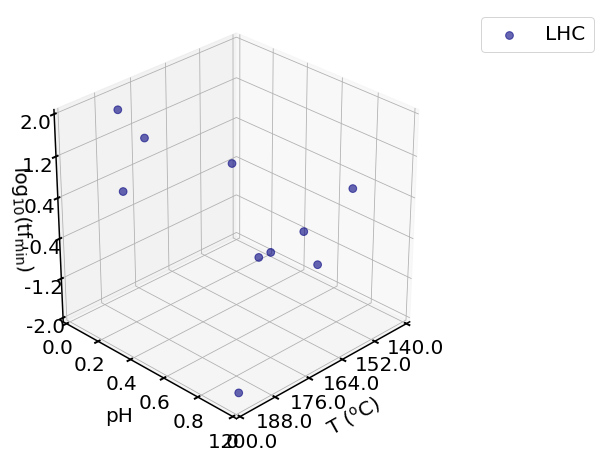

In [7]:
#%% Initial Sampling 
# Latin hypercube design with 10 initial points
n_init_lhc = 10
X_init_lhc = doe.latin_hypercube(n_dim = n_dim, n_points = n_init_lhc, seed= 1)
# Get the initial responses
Y_init_lhc = bo.eval_objective_func(X_init_lhc, X_ranges, objective_func)

# Compare the two sampling plans
plotting.sampling_3d(X_init_lhc, 
                     X_names = X_name_with_unit,
                     X_ranges = X_ranges,
                     design_names = 'LHC')

## 4. Initialize an `Experiment` object 

In this example, we use an `EHVIMOOExperiment` object, a class designed for multi-objective optimization using `Expected Hypervolume Improvement` as aquisition funciton. It can handle multiple weight combinations, perform the scalarized objective optimization automatically, and construct the entire Pareto front. 

An `EHVIMOOExperiment` is a subclass of `Experiment`. It requires all key components as `Experiment`. Additionally, `ref_point` is required for `EHVIMOOExperiment.set_ref_point` function. It defines a list of values that are slightly worse than the lower bound of objective values, where the lower bound is the minimum acceptable value of interest for each objective. It would be helpful if the user know the rough values using domain knowledge prior to optimization. 

In [8]:
#%% Initialize an multi-objective Experiment object
# Set its name, the files will be saved under the folder with the same name
Exp_lhc = bo.EHVIMOOExperiment('PFR_yield_MOO_EHVI')  
# Import the initial data
Exp_lhc.input_data(X_init_lhc, 
                   Y_init_lhc, 
                   X_ranges = X_ranges, 
                   X_names = X_name_with_unit,
                   Y_names = Y_name_with_unit,
                   unit_flag = True)

# Set the optimization specifications 
# here we set the reference point
ref_point = [10.0, 10.0]

# Set a timer
start_time = time.time()
Exp_lhc.set_ref_point(ref_point)
Exp_lhc.set_optim_specs(objective_func = objective_func, 
                        maximize = True)
end_time = time.time()
print('Initializing the experiment takes {:.2f} minutes.'.format((end_time-start_time)/60))

Iter 10/100: 5.538654327392578
Iter 20/100: 5.13447380065918
Iter 30/100: 4.929288387298584
Iter 40/100: 4.781908988952637
Initializing the experiment takes 0.00 minutes.


## 5. Run trials 

`EHVIMOOExperiment.run_trials_auto` can run these tasks automatically by specifying the acqucision function, q-Expected Hypervolume Improvement (`qEHVI`). In this way, we generate one point per iteration in default. Alternatively, we can manually specify the number of next points we would like to obtain.

Some progress status will be printed out during the training. It takes 0.2 miuntes to obtain the whole front, much shorter than the 12.9 minutes in the weighted method. 

In [9]:
# Set the number of iterations for each experiments
n_trials_lhc = 30 

# run trials
# Exp_lhc.run_trials_auto(n_trials_lhc, 'qEHVI')

for i in range(n_trials_lhc):
    # Generate the next experiment point
    X_new, X_new_real, acq_func = Exp_lhc.generate_next_point(n_candidates=4)
    # Get the reponse at this point
    Y_new_real = objective_func(X_new_real) 
    # or 
    # Y_new_real = bo.eval_objective_func(X_new, X_ranges, objective_func)

    # Retrain the model by input the next point into Exp object
    Exp_lhc.run_trial(X_new, X_new_real, Y_new_real)

end_time = time.time()
print('Optimizing the experiment takes {:.2f} minutes.'.format((end_time-start_time)/60))

C:\Users\yifan\Anaconda3\envs\torch\lib\site-packages\scipy\integrate\_ode.py:1182: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


Iter 10/100: 3.7715890407562256
Iter 10/100: 3.3689522743225098
Iter 10/100: 3.1840896606445312
Iter 10/100: 2.70974063873291


C:\Users\yifan\Anaconda3\envs\torch\lib\site-packages\scipy\integrate\_ode.py:1182: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


Iter 10/100: 2.4111485481262207
Iter 10/100: 2.425398349761963
Iter 10/100: 2.2581567764282227
Iter 10/100: 1.9866001605987549
Iter 10/100: 1.9962842464447021
Iter 10/100: 1.8744709491729736
Iter 10/100: 1.855424404144287
Iter 10/100: 1.6954476833343506
Iter 10/100: 1.6489787101745605
Iter 10/100: 0.8870514631271362
Iter 10/100: 0.7392321825027466
Iter 10/100: 0.6144255995750427
Iter 10/100: 0.472586989402771
Iter 10/100: 0.44086122512817383
Iter 10/100: 0.41184794902801514
Iter 10/100: 0.16048449277877808
Iter 20/100: 0.17726176977157593
Iter 10/100: 0.06772303581237793
Iter 10/100: 0.05735445022583008
Iter 20/100: 0.04761612415313721
Iter 10/100: 0.21153199672698975


C:\Users\yifan\Anaconda3\envs\torch\lib\site-packages\scipy\integrate\_ode.py:1182: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


Iter 10/100: 0.13095498085021973
Iter 20/100: 0.016505956649780273
Iter 10/100: -0.07705956697463989
Iter 10/100: -0.17362821102142334
Iter 10/100: -0.2653549909591675
Iter 20/100: -0.2685219645500183


C:\Users\yifan\Anaconda3\envs\torch\lib\site-packages\scipy\integrate\_ode.py:1182: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


Iter 10/100: -0.25494152307510376
Iter 10/100: -0.2396135926246643
Iter 10/100: -0.4094494879245758
Optimizing the experiment takes 0.21 minutes.


## 6. Visualize the Pareto front
We can get the Pareto set directly from the `EHVIMOOExperiment` object by using `EHVIMOOExperiment.get_optim`.

To visualize the Pareto front, `y1` values are plotted against `y2` values. The region below $ y=x $ is infeasible for the PFR model and we have no Pareto points fall below the line, incidating the method is validate. Besides, all sampling points are shown as well.

,T ($\rm ^{o}C $),pH,$\rm log_{10}(tf_{min})$,Yield %,Selectivity %
0,153.12,0.62,-0.53,19.08,62.33
1,147.81,0.34,-1.56,2.54,64.76
2,161.23,0.49,-1.04,16.25,62.76
3,199.85,0.16,-1.87,47.35,57.01
4,181.71,0.02,-1.88,29.02,60.94
5,141.71,0.71,-0.97,2.49,64.96
6,150.12,1.00,-0.08,17.68,62.53
7,191.80,0.57,-1.70,26.75,61.06
8,187.25,0.99,-0.36,47.53,49.20
9,153.83,0.99,-1.05,3.13,64.47


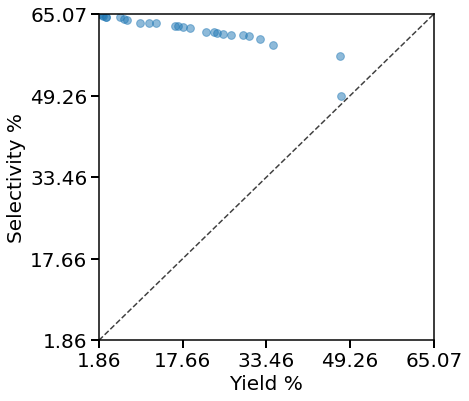

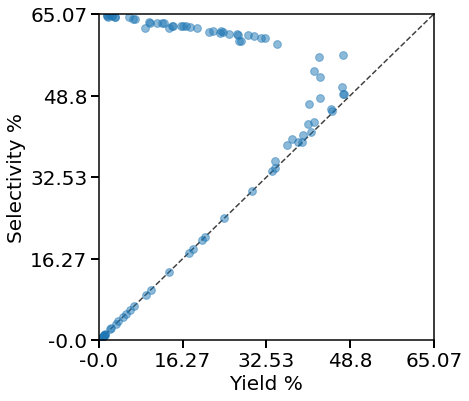

In [10]:
Y_real_opts, X_real_opts = Exp_lhc.get_optim()

# Parse the optimum into a table
data_opt = io.np_to_dataframe([X_real_opts, Y_real_opts], var_names)
display(data_opt.round(decimals=2))

# Make the pareto front
plotting.pareto_front(Y_real_opts[:, 0], Y_real_opts[:, 1], Y_names=Y_name_with_unit, fill=False)

# All sampling points
plotting.pareto_front(Exp_lhc.Y_real[:, 0], Exp_lhc.Y_real[:, 1], Y_names=Y_name_with_unit, fill=False)

## References:

1. Daulton, S.; Balandat, M.; Bakshy, E. Differentiable Expected Hypervolume Improvement for Parallel Multi-Objective Bayesian Optimization. arXiv 2020, No. 1, 1–30.

2. BoTorch tutorials using qHVI: https://botorch.org/tutorials/multi_objective_bo; https://botorch.org/tutorials/constrained_multi_objective_bo

3. Ax tutorial using qHVI: https://ax.dev/versions/latest/tutorials/multiobjective_optimization.html

4. Desir, P.; Saha, B.; Vlachos, D. G. Energy Environ. Sci. 2019.

5. Swift, T. D.; Bagia, C.; Choudhary, V.; Peklaris, G.; Nikolakis, V.; Vlachos, D. G. ACS Catal. 2014, 4 (1), 259–267

6. The PFR model can be found on GitHub: https://github.com/VlachosGroup/Fructose-HMF-Model



[Thumbnail](_images/11.png) of this notebook